In [37]:
# Import Required Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

In [38]:
# ✅ Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [39]:
# To use reconstruction error for anomaly detection, you need an LSTM autoencoder, not a standard LSTM forecaster. 
# My current model (LSTMForecast) predicts the next value(s), but a reconstruction model learns to reproduce its input sequence.

In [40]:
# 1. Define LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1, dropout=0.2):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.enc_fc = nn.Linear(hidden_dim, latent_dim)

        self.dec_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.output = nn.Linear(hidden_dim, input_dim)

        self.dropout = nn.Dropout(dropout)
        # optional layernorm
        self.layernorm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        # x: (B, T, input_dim)
        enc_out, (h_n, c_n) = self.encoder(x)   # enc_out: (B, T, hidden_dim), h_n: (num_layers, B, hidden_dim)
        # take last layer's hidden state
        last_h = h_n[-1]                        # (B, hidden_dim)
        latent = self.enc_fc(last_h)            # (B, latent_dim)

        # expand latent to sequence length
        T = x.size(1)
        dec_input = self.dec_fc(latent)         # (B, hidden_dim)
        # repeat for each timestep
        dec_input_seq = dec_input.unsqueeze(1).repeat(1, T, 1)  # (B, T, hidden_dim)
        dec_input_seq = self.layernorm(dec_input_seq)
        dec_input_seq = self.dropout(dec_input_seq)

        dec_out, _ = self.decoder(dec_input_seq)  # (B, T, hidden_dim)
        out = self.output(dec_out)                # (B, T, input_dim)
        return out

In [41]:
# 2. Prepare sliding window dataset for autoencoder
def create_windows(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data)-window_size)])

In [42]:
# Load Data
train_df = pd.read_csv("../data/processed/etth1_train.csv", parse_dates=["date"], index_col="date")
val_df = pd.read_csv("../data/processed/etth1_val.csv", parse_dates=["date"], index_col="date")
test_data_with_anomalies = np.load("../data/processed/etth1_test_with_anomalies.npy")
anomaly_labels = np.load("../data/processed/etth1_anomaly_labels.npy")

In [43]:
# Normalize Data
scaler= StandardScaler()
tran_scaled= scaler.fit_transform(train_df["OT"].values.reshape(-1, 1)).flatten()
val_scaled = scaler.transform(val_df["OT"].values.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test_data_with_anomalies.reshape(-1, 1)).flatten()

In [44]:
# Create Windows
window_size = 96  # Increased window size for more context
train_windows = create_windows(tran_scaled, window_size)
test_windows = create_windows(test_scaled, window_size)
val_windows = create_windows(val_scaled, window_size)
test_labels = np.array([1 if np.any(anomaly_labels[i:i+window_size]) else 0 for i in range(len(test_windows))])

In [45]:
# 3. DataLoader
train_tensor = torch.tensor(train_windows, dtype=torch.float32).unsqueeze(-1)
test_tensor = torch.tensor(test_windows, dtype=torch.float32).unsqueeze(-1)
val_tensor = torch.tensor(val_windows, dtype=torch.float32).unsqueeze(-1)

train_loader_ae = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=64, shuffle=True)
val_loader_ae = DataLoader(TensorDataset(val_tensor, val_tensor), batch_size=64, shuffle=False)
test_loader_ae = DataLoader(TensorDataset(test_tensor, test_tensor), batch_size=128, shuffle=False)

In [46]:
# Model Hyperparameters
input_dim = 1  # Single feature
hidden_dim = 64  # Increased hidden layer size
latent_dim = 16  # Increased latent space size
num_layers = 2   # More LSTM layers
num_epochs = 100 # More training epochs
patience = 12    # Higher patience for early stopping

In [47]:
# 4. Train LSTM Autoencoder

lstm_autoencoder_model = LSTMAutoencoder(input_dim, hidden_dim, latent_dim, num_layers=num_layers, dropout=0.2).to(device)
optimizer = torch.optim.Adam(lstm_autoencoder_model.parameters(), lr=1e-3, weight_decay=1e-5)  # L2 regularization
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


# ---------------- Training Loop with Early Stopping ---------------- #
best_val_loss = np.inf
patience_counter = 0


for epoch in range(num_epochs):
    lstm_autoencoder_model.train()
    total_loss = 0
    for xb, yb in train_loader_ae:
        xb, yb = xb.to(device), yb.to(device)

        # denoising: small gaussian noise proportional to std
        noisy_input = xb + 0.02 * torch.randn_like(xb)

        optimizer.zero_grad()
        out = lstm_autoencoder_model(noisy_input)
        loss = loss_fn(out, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(lstm_autoencoder_model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()* xb.size(0)

    avg_loss = total_loss / len(train_loader_ae)

    # Validation loss
    lstm_autoencoder_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_ae:
            xb, yb = xb.to(device), yb.to(device)
            out = lstm_autoencoder_model(xb)
            val_loss += loss_fn(out, yb).item()
    avg_val_loss = val_loss / len(val_loader_ae)
    print(f"(lstm_autoencoder) Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_loss:.6f} - Val Loss: {avg_val_loss:.6f}")
    lstm_autoencoder_model.train()

    # Early Stopping (monitoring validation loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = lstm_autoencoder_model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
lstm_autoencoder_model.load_state_dict(best_model_state)

(lstm_autoencoder) Epoch 1/100 - Train Loss: 13.171341 - Val Loss: 0.117792
(lstm_autoencoder) Epoch 2/100 - Train Loss: 6.384048 - Val Loss: 0.055960
(lstm_autoencoder) Epoch 3/100 - Train Loss: 6.002175 - Val Loss: 0.075747
(lstm_autoencoder) Epoch 4/100 - Train Loss: 5.828915 - Val Loss: 0.054362
(lstm_autoencoder) Epoch 5/100 - Train Loss: 5.647539 - Val Loss: 0.055395
(lstm_autoencoder) Epoch 6/100 - Train Loss: 5.594629 - Val Loss: 0.053798
(lstm_autoencoder) Epoch 7/100 - Train Loss: 5.456718 - Val Loss: 0.053316
(lstm_autoencoder) Epoch 8/100 - Train Loss: 5.338453 - Val Loss: 0.053528
(lstm_autoencoder) Epoch 9/100 - Train Loss: 5.520721 - Val Loss: 0.052135
(lstm_autoencoder) Epoch 10/100 - Train Loss: 5.342576 - Val Loss: 0.051883
(lstm_autoencoder) Epoch 11/100 - Train Loss: 5.355673 - Val Loss: 0.071673
(lstm_autoencoder) Epoch 12/100 - Train Loss: 5.286628 - Val Loss: 0.052131
(lstm_autoencoder) Epoch 13/100 - Train Loss: 5.168796 - Val Loss: 0.051153
(lstm_autoencoder) E

<All keys matched successfully>

In [48]:
lstm_autoencoder_model.eval()
recons = []
with torch.no_grad():
    for xb, _ in test_loader_ae:
        xb = xb.to(device)
        out = lstm_autoencoder_model(xb).cpu().numpy()
        recons.append(out)
recons = np.vstack(recons)  # shape (num_windows, T, 1)
recons = recons.squeeze(-1) # (num_windows, T)
test_windows_np = test_windows  # (num_windows, T)

# window-wise MSE (per window)
window_mse = np.mean((recons - test_windows_np)**2, axis=1)

# map window error to pointwise using window center (recommended)
N = test_scaled.shape[0]
pointwise_err = np.zeros(N)
counts = np.zeros(N)
half = window_size // 2
for i, w_err in enumerate(window_mse):
    center_idx = i + half
    if center_idx < N:
        pointwise_err[center_idx] += w_err
        counts[center_idx] += 1
nonzero = counts>0
pointwise_err[nonzero] /= counts[nonzero]

# align with label vector (labels originally length N)
valid_err = pointwise_err[half:len(pointwise_err)]     # or slice appropriately
valid_labels = anomaly_labels[half:len(pointwise_err)]



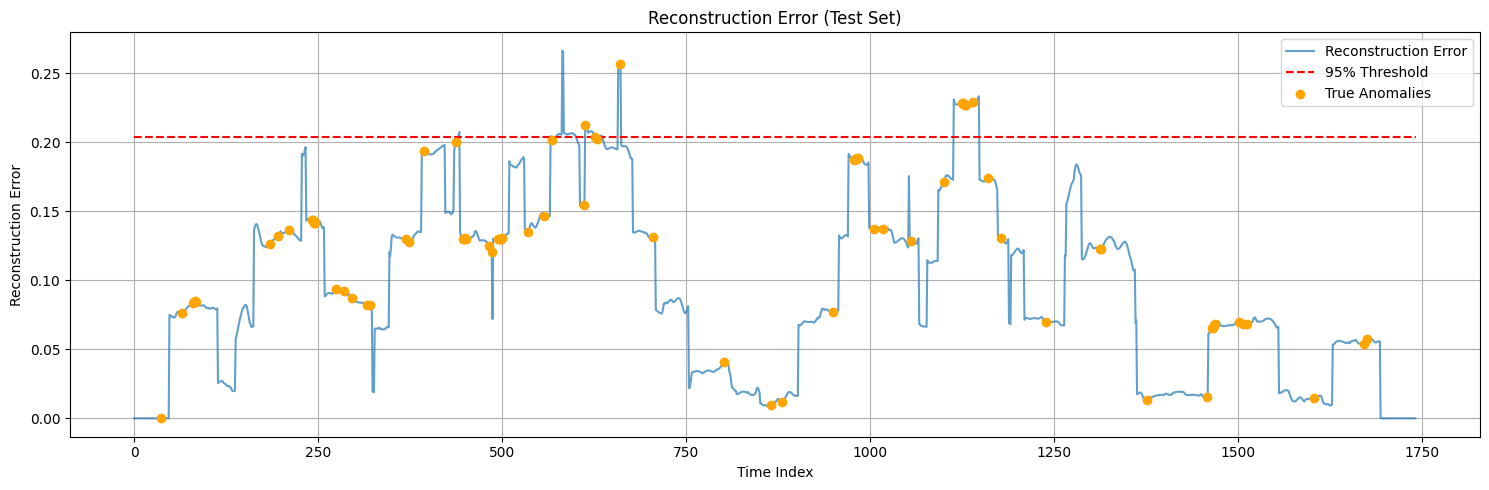

In [49]:
# Plot Reconstruction Error over Time
plt.figure(figsize=(15,5))
plt.plot(pointwise_err, label='Reconstruction Error', alpha=0.7)
plt.hlines(np.percentile(valid_err, 95), 0, len(pointwise_err), colors='r', linestyles='dashed', label='95% Threshold')
plt.scatter(np.where(anomaly_labels==1), pointwise_err[anomaly_labels==1], color='orange', label='True Anomalies', zorder=5)
plt.title('Reconstruction Error (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# 7. Evaluate anomaly detection (If you have anomaly labels, evaluate detection performance)
threshold = np.percentile(valid_err, 95)
predicted_labels = (valid_err > threshold).astype(int)

# Compute Evaluation Metrics
roc_auc = roc_auc_score(valid_labels, valid_err)
precision, recall, f1 = precision_score(valid_labels, predicted_labels), recall_score(valid_labels, predicted_labels), f1_score(valid_labels, predicted_labels)
ap_score = average_precision_score(valid_labels, valid_err)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AP: {ap_score:.4f}")

ROC AUC: 0.6365
Precision: 0.1059, Recall: 0.1071, F1: 0.1065, AP: 0.0868


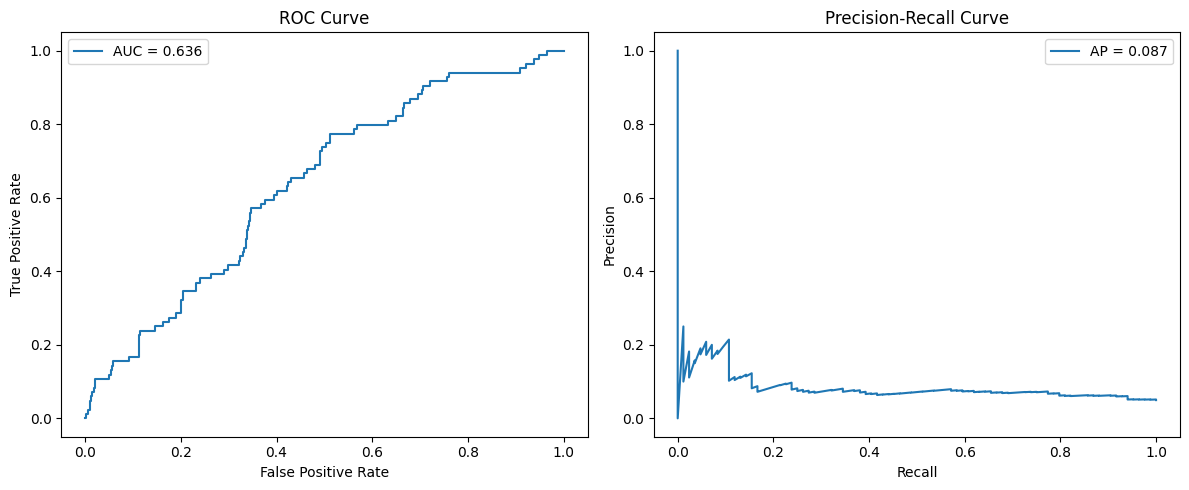

In [51]:
# 8. Plot ROC and Precision-Recall Curves
fpr, tpr, _ = roc_curve(valid_labels, valid_err)
prec_curve, rec_curve, _ = precision_recall_curve(valid_labels, valid_err)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec_curve, prec_curve, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve"); plt.legend()

plt.tight_layout()
plt.show()


Confusion Matrix as string:
[[1534   76]
 [  75    9]]


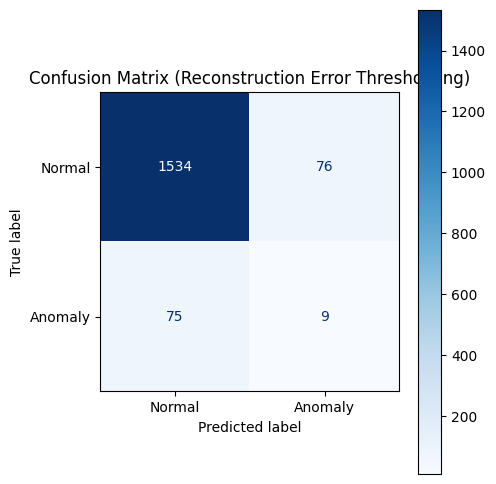

In [52]:
# 9. Plot confusion matrix
cm = confusion_matrix(valid_labels, predicted_labels)

print("Confusion Matrix as string:")
print(str(cm))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Reconstruction Error Thresholding)")
plt.tight_layout()
plt.show()

# Step-by-Step Model Improvement Plan

This notebook applies several improvements to the LSTM autoencoder anomaly detection pipeline:

1. **Increase Model Capacity:**
   - Larger hidden and latent dimensions, more LSTM layers.
2. **Add Validation Set:**
   - Split training data for validation, use validation loss for early stopping.
3. **Train Longer:**
   - More epochs and higher patience for early stopping.
4. **Tune Window Size:**
   - Try a larger window size for more context.
5. **Use L2 Regularization:**
   - Add weight decay to the optimizer.
6. **Threshold Selection:**
   - Use ROC/PR curves to select the best threshold for anomaly detection.

Each step is explained and implemented in the following cells.

Best threshold by F1: 0.212312, F1: 0.1429
ROC AUC: 0.6365
Precision: 0.1951, Recall: 0.0952, F1: 0.1280, AP: 0.0868
Confusion Matrix as string:
[[1577   33]
 [  76    8]]


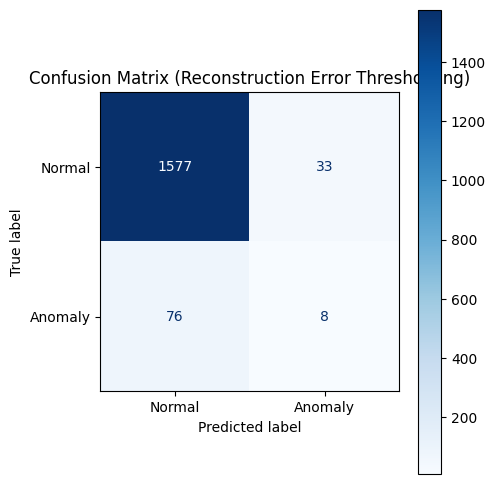

In [54]:
# Step 6: Use ROC/PR curve to select best threshold
from sklearn.metrics import f1_score

prec_curve, rec_curve, thresholds = precision_recall_curve(valid_labels, valid_err)
f1_scores = 2 * (prec_curve * rec_curve) / (prec_curve + rec_curve + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold by F1: {best_threshold:.6f}, F1: {f1_scores[best_idx]:.4f}")
predicted_labels = (valid_err > best_threshold).astype(int)

# Compute Evaluation Metrics
roc_auc = roc_auc_score(valid_labels, valid_err)
precision, recall, f1 = precision_score(valid_labels, predicted_labels), recall_score(valid_labels, predicted_labels), f1_score(valid_labels, predicted_labels)
ap_score = average_precision_score(valid_labels, valid_err)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AP: {ap_score:.4f}")

# 9. Plot confusion matrix
cm = confusion_matrix(valid_labels, predicted_labels)

print("Confusion Matrix as string:")
print(str(cm))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Reconstruction Error Thresholding)")
plt.tight_layout()
plt.show()